### What is the competition?

This competition is about identifying and localizing COVID-19 abnormalities on chest radiographs. We need to categorize a given chest radiograph image into 4 different classes namely;

* Negative for Pneumonia
* Typical Appearance 
* Indeterminate Appearance
* Atypical Appearance

Alogn with that we need to predicta bounding box that describes the abnormalities. Hence this is a This is an object detection/localization and classification problem. The train and test images given in this competition are in DICOM format. 

### What is DICOM?

DICOM® — [Digital Imaging and Communications in Medicine](https://www.dicomstandard.org) — is the ISO recognized international standard for medical images and related information. It defines the formats for medical images that can be exchanged with the data and quality necessary for clinical use.

### What is Object Detection?
A typical usage of convolutional neural network is to classify an image into respective classes. For example Dog vs Cat or Classifying the handwritten digits like the MNIST dataset. However, Object detection is about identifying where a particular object(s) is in the given image and to classify it. Object localization is to define a bounding box (the location) of the classified object within the image. An example is given below. 

![YOLO-Object-Detection](https://user-images.githubusercontent.com/48846576/119601441-cca11500-bdae-11eb-8711-8e0b2683dd19.png)
 <div align='center'>Source: You Only Look Once: Unified, Real-Time Object Detection https://pjreddie.com/darknet/yolo/</div>


In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_white"
%matplotlib inline
import gc

from colorama import Fore, Back, Style

y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
res = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install python-gdcm

     |████████████████████████████████| 9.4 MB 1.3 MB/s 


<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Load and Explore Data</b></div>


In [3]:
PATH = '/kaggle/input/siim-covid19-detection/'
submission = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv', index_col=None)
image_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_image_level.csv', index_col=None)
study_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_study_level.csv', index_col=None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
print(f"{y_}Train image level csv shape : {image_df.shape}{res}\n{g_}Train study level csv shape : {study_df.shape}{res}")

Train image level csv shape : (6334, 4)
Train study level csv shape : (6054, 5)


In [4]:
import os
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [5]:
study_df

id  Negative for Pneumonia  Typical Appearance  \
0     00086460a852_study                       0                   1   
1     000c9c05fd14_study                       0                   0   
2     00292f8c37bd_study                       1                   0   
3     005057b3f880_study                       1                   0   
4     0051d9b12e72_study                       0                   0   
...                  ...                     ...                 ...   
6049  ffcb4630f46f_study                       0                   1   
6050  ffe4d6e8fbb0_study                       0                   1   
6051  ffe94fcb14fa_study                       0                   1   
6052  ffebf1ef4a9c_study                       0                   1   
6053  fff649d65f62_study                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    1  
2                            0                    0  
3                            0                    0  
4                            0                    1  
...                        ...                  ...  
6049                         0                    0  
6050                         0                    0  
6051                         0                    0  
6052                         0                    0  
6053                         0                    0  

[6054 rows x 5 columns]

In [6]:
image_df

id  \
0     000a312787f2_image   
1     000c3a3f293f_image   
2     0012ff7358bc_image   
3     001398f4ff4f_image   
4     001bd15d1891_image   
...                  ...   
6329  ffcc6edd9445_image   
6330  ffd91a2c4ca0_image   
6331  ffd9b6cf2961_image   
6332  ffdc682f7680_image   
6333  ffe942c8655f_image   

                                                                                                                                                                                                                                    boxes  \
0                                                                             [{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]   
1                                                                                                                                                                                                                                     NaN   
2                                                                                   [{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]   
3                                                                                                                                                                       [{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]   
4                                                                                                      [{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]   
...                                                                                                                                                                                                                                   ...   
6329                                                                                                                                                                                                                                  NaN   
6330                                                                                                                                                                                                                                  NaN   
6331  [{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]   
6332                                                                           [{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]   
6333                                                                                  [{'x': 208.86463, 'y': 91.53448, 'width': 450.96747, 'height': 628.05473}, {'x': 755.52522, 'y': 144.33069, 'width': 427.8692, 'height': 547.7605}]   

                                                                                                                                                                               label  \
0                                                                            opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472   
1                                                                                                                                                                     none 1 0 0 1 1   
2                                                                             opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105   
3                                                                                                       

In [7]:
study_grp = pd.melt(study_df, id_vars=list(study_df.columns)[:1], value_vars=list(study_df.columns)[1:],
             var_name='label', value_name='value')
study_grp = study_grp.loc[study_grp['value']!=0]
colors = {'Typical Appearance' : '#DCD427',
'Negative for Pneumonia' : '#0092CC',
'Indeterminate Appearance' : '#CC3333',
#'Atypical Appearance' : '#779933',
          'Atypical Appearance' : '#E6E6E6'
         }

study_grp = study_grp.groupby('label').sum().sort_values('value',ascending=False).reset_index()
study_grp['color'] = study_grp['label'].apply(lambda x: colors[x])
study_grp

label  value    color
0        Typical Appearance   2855  #DCD427
1    Negative for Pneumonia   1676  #0092CC
2  Indeterminate Appearance   1049  #CC3333
3       Atypical Appearance    474  #E6E6E6

In [8]:
def plot_study_label(df):
    pio.templates.default = "plotly_dark"
    fig = px.bar(df, x='label', y='value',
             hover_data=['label', 'value'], color='label',
             #labels={column: label},
             color_discrete_map=colors,
             text='value')
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': df['label'],
                             'title' : None, 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Count'},
                      showlegend=False,
                     title = 'Study samples in train data')
    fig.update_traces(textfont_size=16)
    fig.show()


In [9]:
plot_study_label(study_grp)

In [10]:
study_grp['pct'] = round((study_grp['value'] / study_grp['value'].sum())*100,2)

fig = go.Figure(data=[go.Pie(labels=study_grp['label'],
                             values=study_grp['pct'],
                             hole=.3,
                             pull=[0.1, 0.1, 0.1, 0.1]
                            )
                     ]
               )
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=16,
                  marker=dict(colors=study_grp['color'], line=dict(color='#000000', width=2))
                 )
fig.update_layout(title={'text': "% of labels in training data",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>DICOM Image</b></div>


### Overview 
DICOM - Digital Imaging and Communication in Medicine is a standard format for encoding and transmitting medical images. This format stores image metadata like patient information, image acquistion parameters, image size, pixel size, etc along with the actual image. The image metadata is stored in the DICOM header. The image pixel data may be compressed using various techniques like JPEG, lossless JPEG, run length encoding (RLE), etc. Let's load a sample image to look at its header (metadata) and the actual pixel_array.

### Bit-Depth

The pixel range of an image format is determined by its bit-depth. The range is $ [0, 2^{bitdepth} -1] $. For example, an 8-bit image will have a range of $[0, 2^{8} -1] = [0, 255]$. Most of the common photographic formats such as JPEG, PNG, etc use 8 bits for storage and only have positive values. A JPEG image containing 3 channels (RGB) will have a bit-depth of 8 for each channel hence a total bit-depth of 24.

However, medical images use a higher bit-depth since higher accuracy is needed. For example the sample image metadata shown below uses ((0028, 0100) Bits Allocated field) uses 16 bits. Hence the range of pixel values for a 16 bit image is $[0, 65535] $ for a total of $2^{16} = 65536$ values. 


In [11]:
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file
file_path = PATH+"train/00086460a852/9e8302230c91/65761e66de9f.dcm"
dicom = read_file(file_path, stop_before_pixels=False)

In [12]:
dicom

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                          DA: '4545ba78b753'
(0008, 0030) Study Time                          TM: 'bf1677526b2b'
(0008, 0050) Accession Number                    SH: '5f20f119e3df'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010

In [13]:
img=dicom.pixel_array
type(img), img.shape

(numpy.ndarray, (2330, 2783))

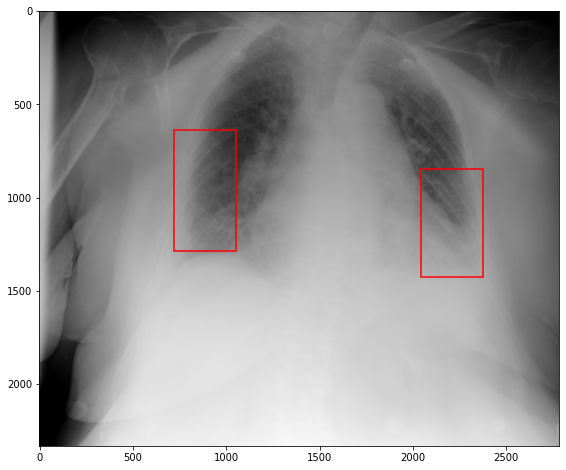

In [14]:
box = image_df.loc[image_df['id']=='65761e66de9f_image'].reset_index(drop=True)
from ast import literal_eval

import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, cmap="gray")
# Create a Rectangle patch
rect1 = patches.Rectangle((720.65215, 636.51048), 332.19348, 648.12561, linewidth=1.5, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((2044.77989, 847.90622), 329.87049, 576.11169, linewidth=1.5, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

Let's display sample images..

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Display Samples</b></div>


In [15]:
from ast import literal_eval
def get_samples(num):
    study_df_grp = pd.melt(study_df, id_vars=list(study_df.columns)[:1], value_vars=list(study_df.columns)[1:],
             var_name='label', value_name='value')
    study_df_grp = study_df_grp.loc[study_df_grp['value']!=0].reset_index(drop=True)
    labels = list(study_df_grp['label'].unique())
    study_samples = {}
    for label in labels:
        study_ids = study_df_grp.loc[study_df_grp['label'] == label].sample(num)['id'].tolist() #Get num sample rows from the datafame
        samples = []
        for study_id in study_ids:
            image = {}
            study_instance_id = study_id.split('_')[0]
            image_id = image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['id'].values[0].split('_')[0] #Get the image matching study id
            file_name = [string for string in all_files if image_id in string]
            image['study_id'] = study_instance_id
            image['dicom_file'] = file_name[0]
            #Get the bounding boxes
            box = None
            try:
                box = literal_eval(image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['boxes'].values[0])
            except ValueError:
                pass
            image['boxes'] = box
            samples.append(image)
        study_samples[label] = samples
    return study_samples

samples = get_samples(6)

def display_all_class_samples():
    ''' Input : List of samples 
    '''
    all_class_samples = []
    for key in samples:
        sample_dict = samples[key][0]
        sample_dict['class'] = key
        all_class_samples.append(sample_dict)
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(all_class_samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if 'boxes' in item and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('{}'.format(item['class']),fontsize = 18)    
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Samples across all classes',fontsize = 20)
    plt.show()

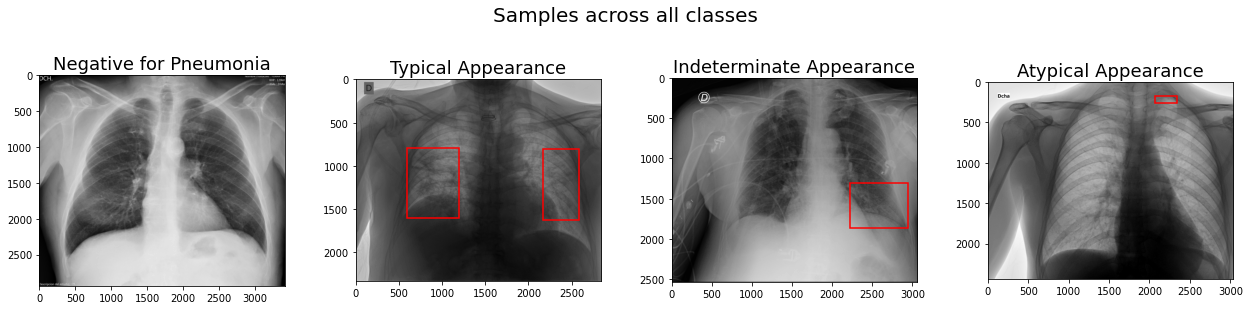

In [16]:
display_all_class_samples()

In [17]:
def display_samples(samples, title, draw_boxes=False):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if draw_boxes == True and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle(title,fontsize = 20)
    plt.show()

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Negative for Pneumonia</b></div>


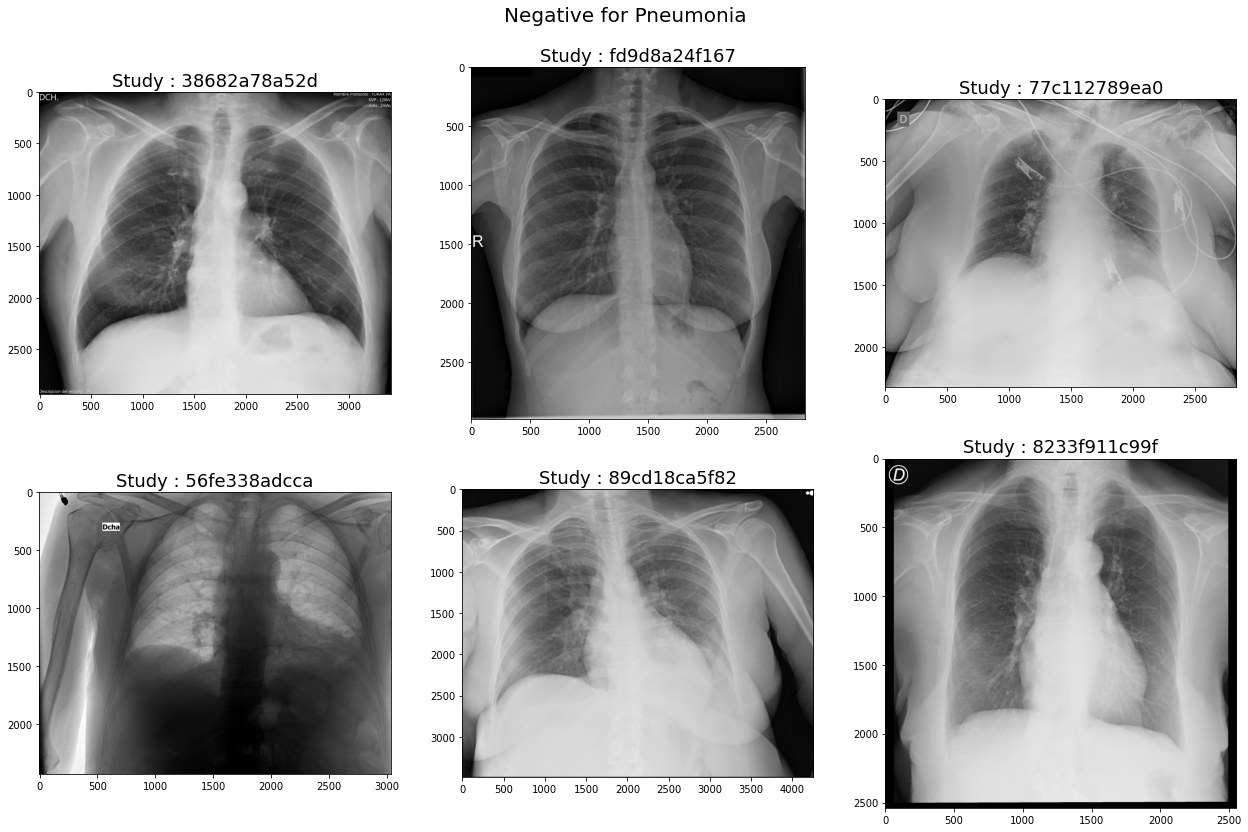

In [18]:
display_samples(samples['Negative for Pneumonia'],'Negative for Pneumonia')

In [19]:
def display_histogram(samples, title):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        sub_plot = sns.histplot(img.flatten(), ax=ax)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Image Histogram - {}'.format(title),fontsize = 20)
    plt.show()


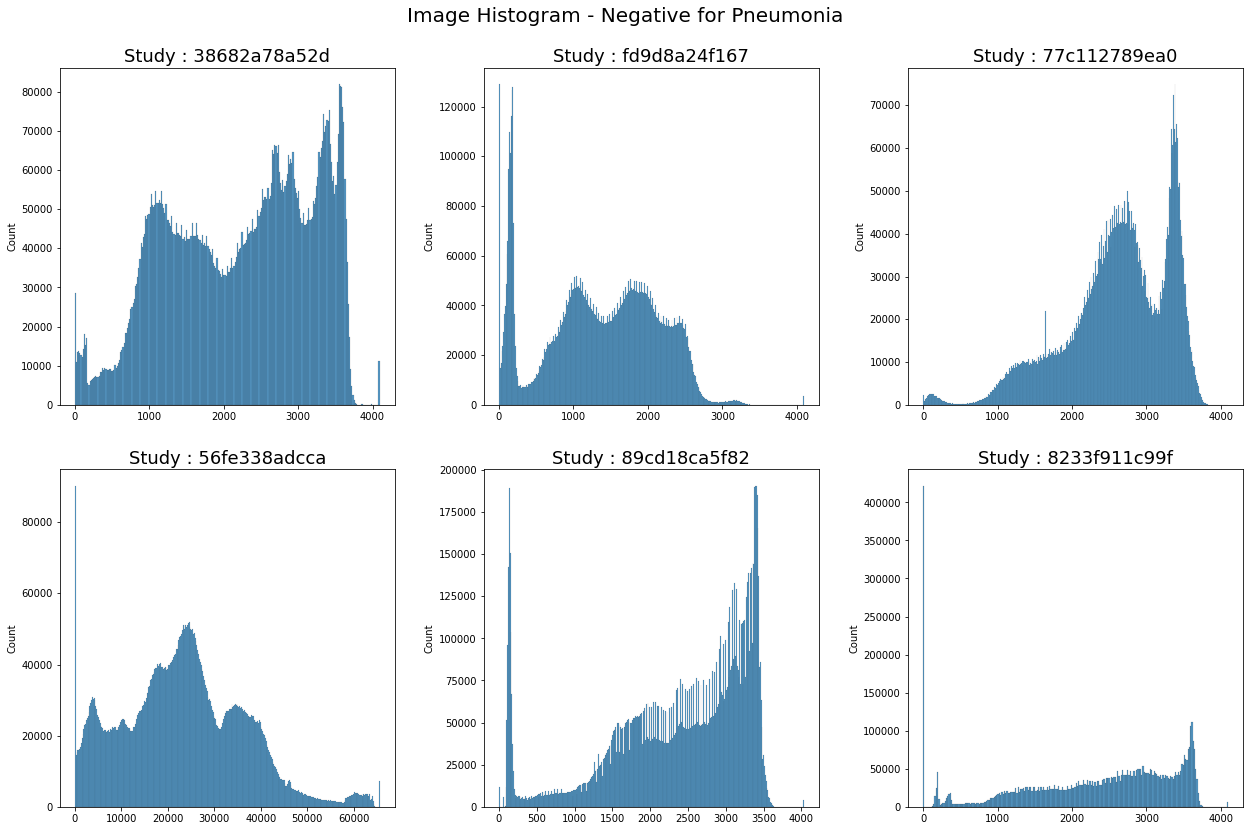

In [20]:
display_histogram(samples['Negative for Pneumonia'],'Negative for Pneumonia')

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Typical Appearance</b></div>


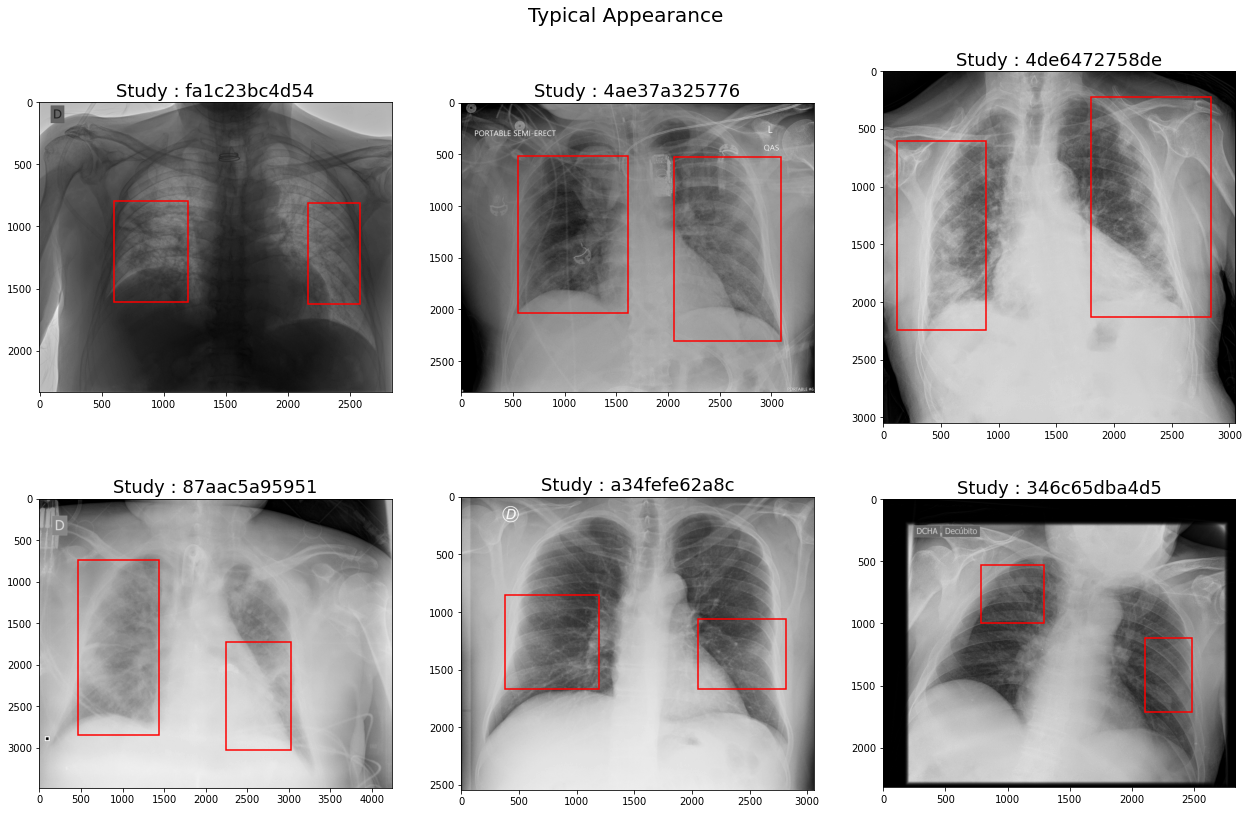

In [21]:
display_samples(samples['Typical Appearance'],'Typical Appearance', draw_boxes=True)

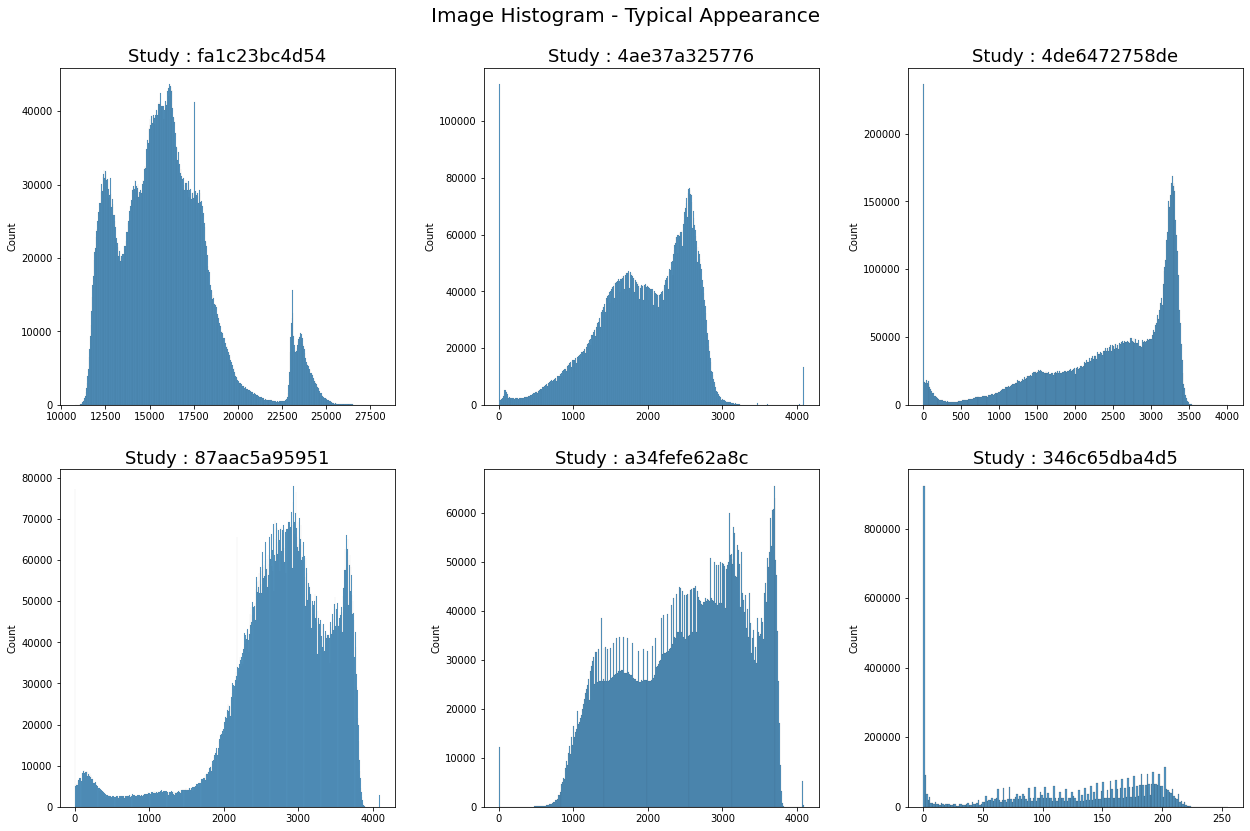

In [22]:
display_histogram(samples['Typical Appearance'],'Typical Appearance')

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Indeterminate Appearance</b></div>


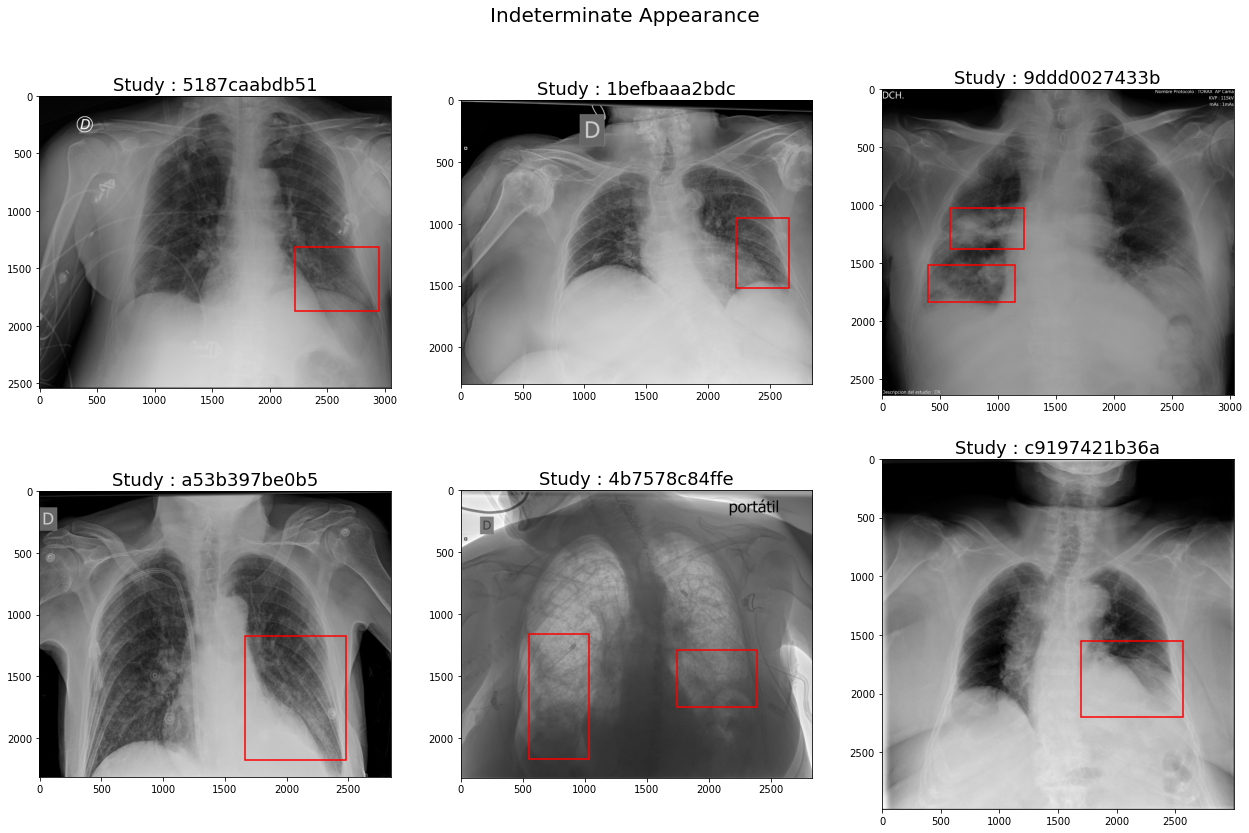

In [23]:
display_samples(samples['Indeterminate Appearance'],'Indeterminate Appearance', draw_boxes=True)

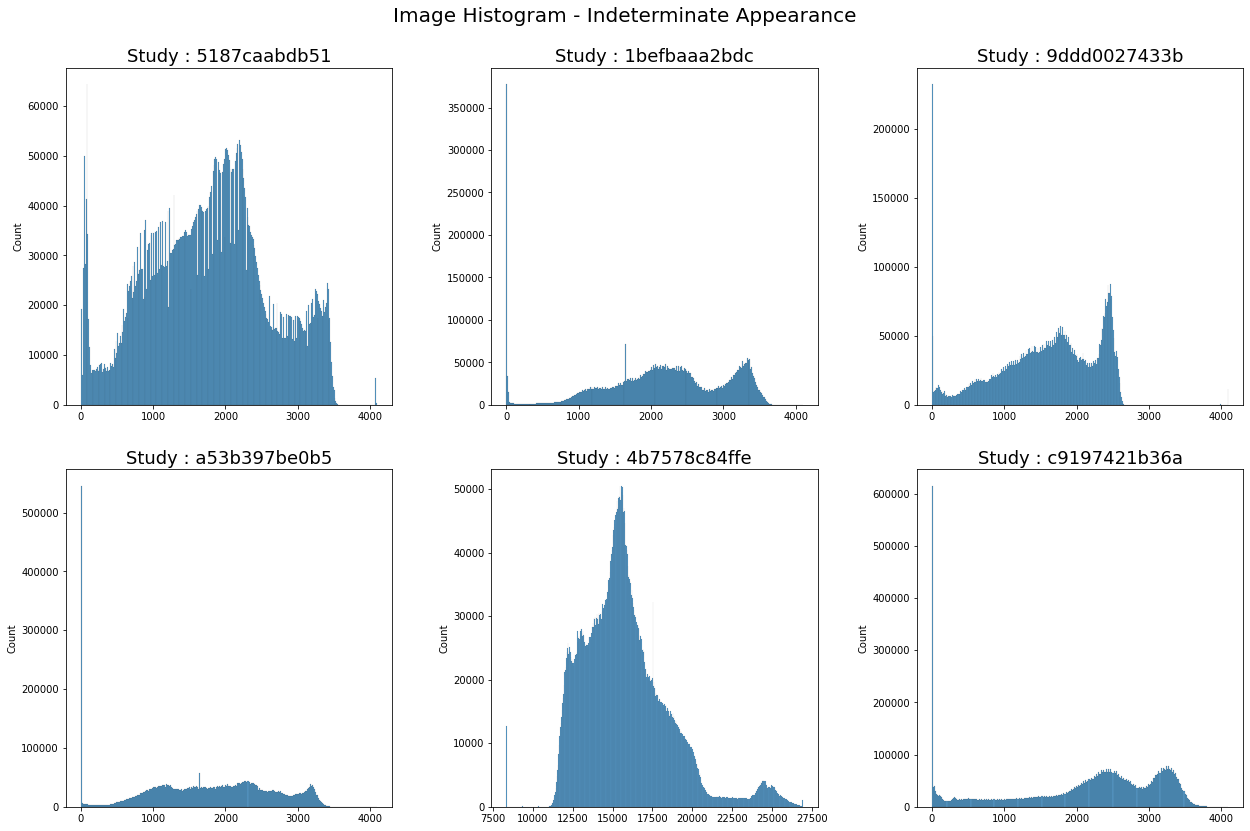

In [24]:
display_histogram(samples['Indeterminate Appearance'],'Indeterminate Appearance')

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Atypical Appearance</b></div>


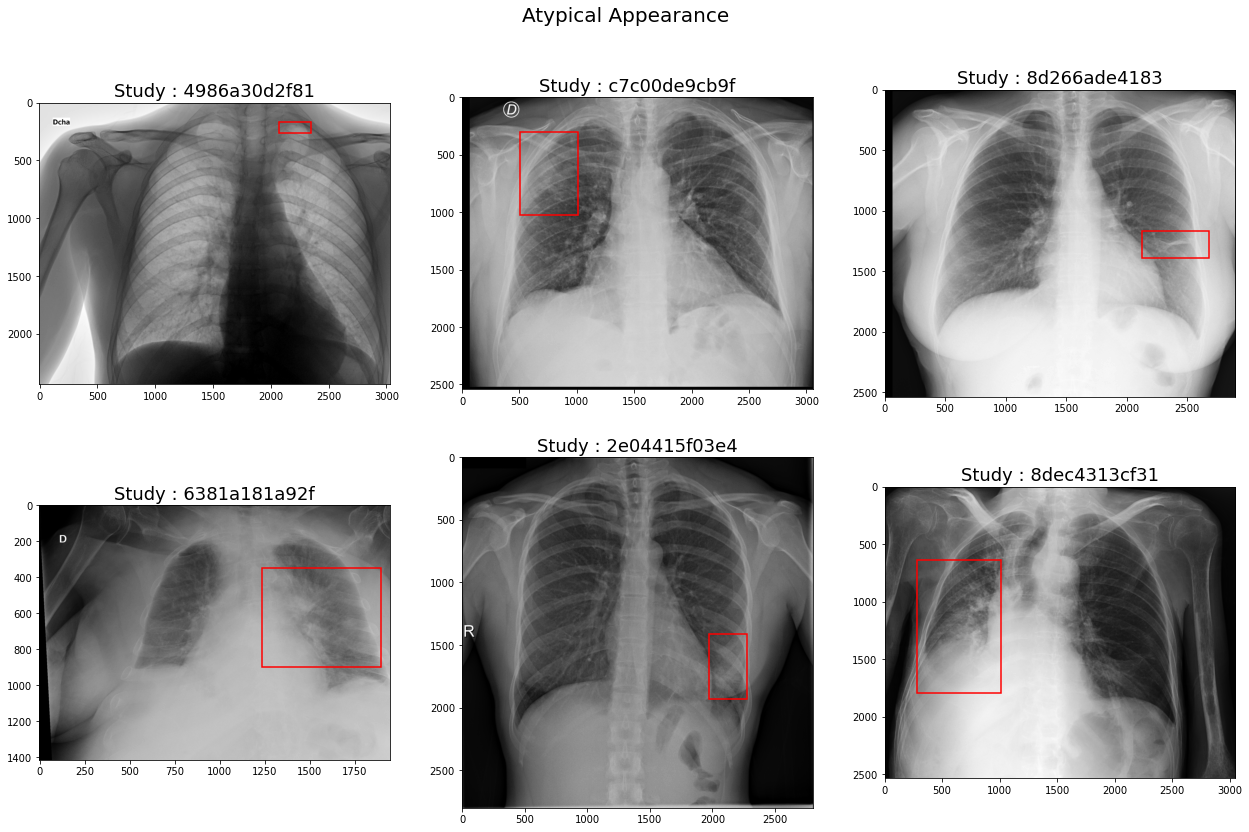

In [25]:
display_samples(samples['Atypical Appearance'],'Atypical Appearance', draw_boxes=True)

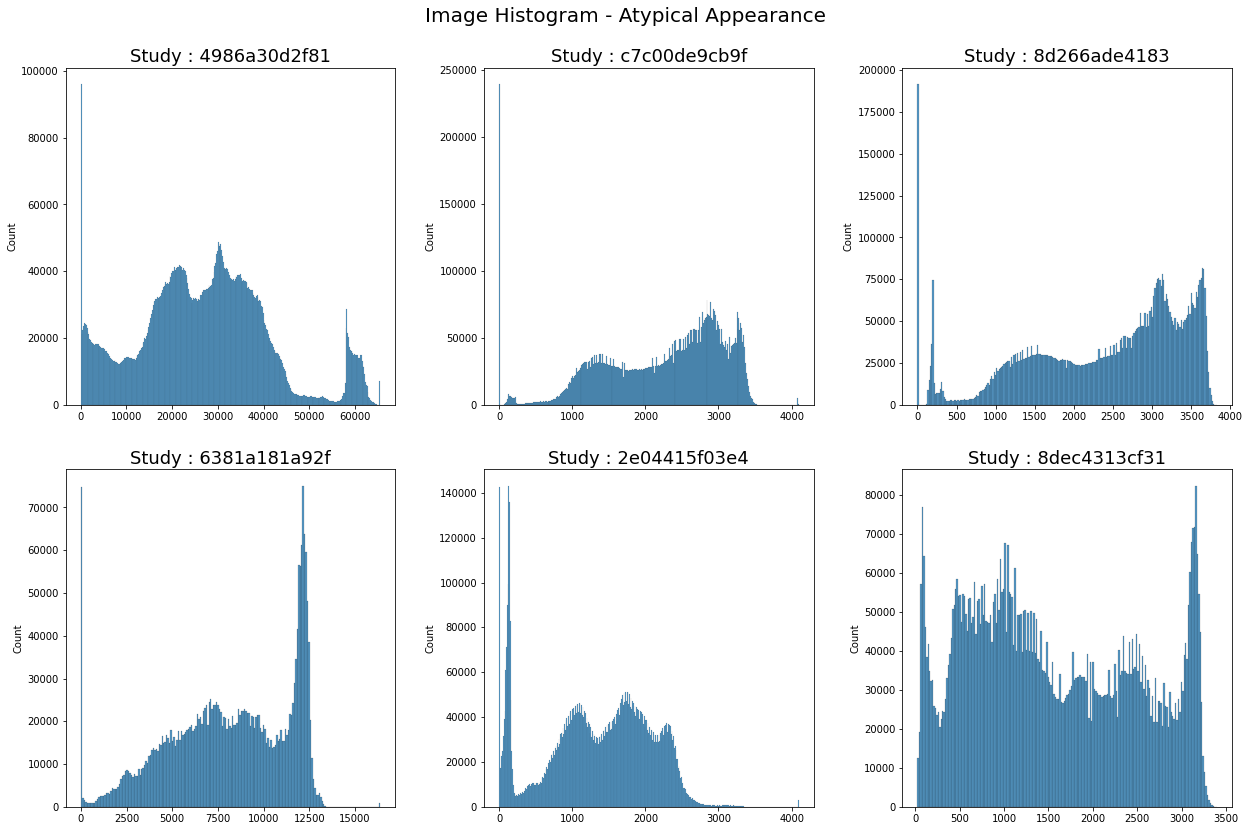

In [26]:
display_histogram(samples['Atypical Appearance'],'Atypical Appearance')

<div style="background-color:#fdb913; font-size:120%;  font-family:sans-serif; text-align:center"><b>Extract Metadata from DICOM Files</b></div>


In [27]:
def get_files(file_format):
    files=[]
    train_files = []
    for file in all_files:
        if file_format in file:
            files.append(file)
    return files
train_files = get_files('/train/')
test_files = get_files('/test/')

In [28]:
from pydicom.tag import Tag
from tqdm import tqdm
pvt_creator1 = Tag(0x2001, 0x10) #Private Creator 1
pvt_creator2 = Tag(0x0903, 0x10) #Private Creator 1

columns = [ 'StudyID',
 'StudyInstanceUID',
 'PatientSex', 
 'BitsAllocated',
 'BitsStored',
 'Columns',
 'Rows',
 'BodyPartExamined', 
 'HighBit', 
 'ImageType',
 'ImagerPixelSpacing',
 'InstanceNumber',
 'Modality',
 'PatientID',
 'PatientName',
 'AccessionNumber',
 'DeidentificationMethod',
 #'DeidentificationMethodCodeSequence',
 'PhotometricInterpretation',
 'PixelRepresentation',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyTime',
 'PrivateCreator1',
 'PrivateCreator2']

def extract_metadata(columns, files):
    df = pd.DataFrame(columns=columns)
    for num, file in tqdm(enumerate(files)):
        row = {}
        dicom_img = read_file(file, stop_before_pixels=True)
        for col in columns:
            if col not in ['PrivateCreator1', 'PrivateCreator2']:
                row[col] = dicom_img[col].value
        try:        
            row['PrivateCreator1'] = dicom_img.get_item(pvt_creator1).value
            row['PrivateCreator2'] = dicom_img.get_item(pvt_creator2).value    
        except AttributeError:
            pass
        df = df.append(row,ignore_index=True)
    return df

In [29]:
train_df = extract_metadata(columns, train_files)

6334it [03:47, 27.86it/s]


In [30]:
test_df = extract_metadata(columns, test_files)

1263it [00:42, 30.01it/s]


In [31]:
train_df['Rows'] = train_df['Rows'].astype(int)
train_df['Columns'] = train_df['Columns'].astype(int)
test_df['Rows'] = test_df['Rows'].astype(int)
test_df['Columns'] = test_df['Columns'].astype(int)
train_df.to_csv('train_imgs_meta.csv', index=None)
test_df.to_csv('test_imgs_meta.csv', index=None)

### Metadata of train images

In [32]:
train_df

StudyID StudyInstanceUID PatientSex BitsAllocated BitsStored  \
0     55625fb42f3f     cd5dd5e6f3f5          M            16         15   
1     55625fb42f3f     49358afcfb80          M            16         12   
2     55625fb42f3f     e4b50e7402c3          M            16         12   
3     55625fb42f3f     e4b50e7402c3          M            16         12   
4     55625fb42f3f     92aad2d01be8          M            16         12   
...            ...              ...        ...           ...        ...   
6329  55625fb42f3f     485d4ccd3c0e          M            16         12   
6330  55625fb42f3f     59d10129bc08          F            16         12   
6331  55625fb42f3f     59d10129bc08          F            16         12   
6332  55625fb42f3f     e6ade0ee672e          F             8          8   
6333  55625fb42f3f     22353f3ff2d1          M            16         12   

      Columns  Rows BodyPartExamined HighBit            ImageType  \
0        2836  2336            CHEST      14  [ORIGINAL, PRIMARY]   
1        4256  3488            CHEST      11  [ORIGINAL, PRIMARY]   
2        2846  2330            CHEST      11  [ORIGINAL, PRIMARY]   
3        2846  2330            CHEST      11  [ORIGINAL, PRIMARY]   
4        4256  3488            CHEST      11  [ORIGINAL, PRIMARY]   
...       ...   ...              ...     ...                  ...   
6329     3050  2539            TORAX      11   [DERIVED, PRIMARY]   
6330     2832  2320            CHEST      11   [DERIVED, PRIMARY]   
6331     2832  2320            CHEST      11  [ORIGINAL, PRIMARY]   
6332     2832  2320            CHEST       7  [ORIGINAL, PRIMARY]   
6333     3056  2544            CHEST      11   [DERIVED, PRIMARY]   

     ImagerPixelSpacing InstanceNumber Modality     PatientID  \
0          [0.15, 0.15]              1       DX  cc5e0ad1a536   
1            [0.1, 0.1]              1       DX  3c6db652d71e   
2        [0.148, 0.148]              1       CR  babb02055d89   
3        [0.148, 0.148]              1       CR  babb02055d89   
4            [0.1, 0.1]              2       DX  dcc3fdf6426a   
...                 ...            ...      ...           ...   
6329     [0.139, 0.139]              1       DX  a515f374caf8   
6330       [0.15, 0.15]              1       CR  dfe0950719d7   
6331       [0.15, 0.15]              1       CR  dfe0950719d7   
6332       [0.15, 0.15]              1       CR  0782f59df095   
6333     [0.139, 0.139]              1       DX  16586c48fac8   

                               PatientName AccessionNumber  \
0     (1, d, f, 0, 3, 0, 4, 6, 2, 4, f, 5)    c4aef4fc15a2   
1     (c, 3, 3, 9, 2, f, 0, 6, a, 4, 0, 1)    179cea9403ed   
2     (e, 7, b, b, d, f, 4, b, 2, 4, 1, 2)    dc2b1c79543a   
3     (e, 7, b, b, d, f, 4, b, 2, 4, 1, 2)    dc2b1c79543a   
4     (d, 4, 2, 6, 8, f, 2, 6, e, d, 0, 5)    14a2a048836a   
...                                    ...             ...   
6329  (8, 2, 4, 1, 9, e, 9, b, 3, a, 1, c)    4b106e5f1dd4   
6330  (e, 9, 1, 0, f, 3, 6, 5, 3, 3, f, d)    8310578fb9cf   
6331  (e, 9, 1, 0, f, 3, 6, 5, 3, 3, f, d)    8310578fb9cf   
6332  (4, c, 1, 5, a, 7, b, 1, 9, 1, c, e)    7c5c0999e2ba   
6333  (0, a, d, c, 3, 4, 6, 0, 0, 4, b, 6)    5abf04774a30   

                                                DeidentificationMethod  \
0     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
1     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
2     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
3     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
4     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
...                                                                ...   
6329  CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
6330  CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
6331  CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
6332  CTP Defau

In [33]:
train_df['PatientSex'].value_counts().reset_index()\
    .style.background_gradient(subset=['PatientSex'], cmap='winter_r')\

In [34]:
train_df['BodyPartExamined'].value_counts().reset_index()\
    .style.background_gradient(subset=['BodyPartExamined'], cmap='nipy_spectral_r')\

In [35]:
train_df['BitsStored'] = train_df['BitsStored'].astype(int)
def combine_image_size(row):
    return str(row['Rows']) + ',' + str(row['Columns'])
train_df['ImageSize'] = train_df.apply(lambda x: combine_image_size(x), axis=1)

In [36]:
fig = go.Figure(go.Scattergl(
    x=train_df['Rows'], y=train_df['Columns'],
    name='Image Size',
    mode='markers',  
    marker=dict(
        color='#0092CC',
    )
))
fig.update_layout(xaxis={'title' : 'Rows', 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Columns'},
                      showlegend=False,
                     title = 'Train - image size')
fig.update_traces(textfont_size=16)
fig.show()



### Metadata of test images

In [37]:
test_df

StudyID StudyInstanceUID PatientSex BitsAllocated BitsStored  \
0     5f5361b32eff     2fb11712bc93          M            16         15   
1     55625fb42f3f     19c66935e737          M            16         12   
2     55625fb42f3f     2fc50bf199cd          M            16         12   
3     55625fb42f3f     97c5d6eb413d          F            16         12   
4     55625fb42f3f     593c3f815635          F            16         12   
...            ...              ...        ...           ...        ...   
1258  55625fb42f3f     b12d2e5c39b7          F            16         15   
1259  55625fb42f3f     6484393291ea          F            16         12   
1260  55625fb42f3f     6484393291ea          F            16         12   
1261  55625fb42f3f     531aa20ff7c3          F            16         12   
1262  55625fb42f3f     9852d2660b69          M            16         12   

      Columns  Rows BodyPartExamined HighBit             ImageType  \
0        2828  2320            CHEST      14   [ORIGINAL, PRIMARY]   
1        2382  2330            CHEST      11   [ORIGINAL, PRIMARY]   
2        3344  2422            CHEST      11  [DERIVED, PRIMARY, ]   
3        1387  1140            CHEST      11   [ORIGINAL, PRIMARY]   
4        2383  2318            CHEST      11    [DERIVED, PRIMARY]   
...       ...   ...              ...     ...                   ...   
1258     2836  2336            CHEST      14   [ORIGINAL, PRIMARY]   
1259     4240  3480            CHEST      11   [ORIGINAL, PRIMARY]   
1260     4240  3480            CHEST      11    [DERIVED, PRIMARY]   
1261     4240  3480            CHEST      11   [ORIGINAL, PRIMARY]   
1262     2832  2320            CHEST      11   [ORIGINAL, PRIMARY]   

        ImagerPixelSpacing InstanceNumber Modality     PatientID  \
0             [0.15, 0.15]              1       CR  688e09b41e61   
1           [0.148, 0.148]              1       CR  1225daa42636   
2           [0.125, 0.125]              1       DX  04afa63f3f29   
3     [0.308553, 0.308553]              1       CR  2b93062744c2   
4           [0.139, 0.139]              1       DX  10eb007f6935   
...                    ...            ...      ...           ...   
1258          [0.15, 0.15]              1       DX  7a96ac853642   
1259            [0.1, 0.1]              1       CR  5d623288671c   
1260            [0.1, 0.1]              1       CR  5d623288671c   
1261            [0.1, 0.1]              1       CR  5d623288671c   
1262          [0.15, 0.15]              1       CR  66924ced4160   

                               PatientName AccessionNumber  \
0     (6, 8, 8, e, 0, 9, b, 4, 1, e, 6, 1)    9f783bbc1c1d   
1     (0, 9, 4, 3, 9, 1, b, e, 7, 8, 2, 3)    87abc2cc17b2   
2     (0, 4, a, f, a, 6, 3, f, 3, f, 2, 9)    0db5787996e1   
3     (7, 2, b, a, 4, 1, d, 5, 6, 2, a, c)    18256f7a0773   
4     (1, 0, e, b, 0, 0, 7, f, 6, 9, 3, 5)    6eca5bafefd6   
...                                    ...             ...   
1258  (3, 7, 9, a, 7, e, 4, a, 3, a, 0, e)    42caa9db5613   
1259  (f, b, 2, 7, 0, 8, b, 5, 1, 6, b, 9)    5ec157989a37   
1260  (f, b, 2, 7, 0, 8, b, 5, 1, 6, b, 9)    5ec157989a37   
1261  (f, b, 2, 7, 0, 8, b, 5, 1, 6, b, 9)    fec6801d0dc6   
1262  (f, 7, 4, a, 2, 0, 6, 9, 0, f, 1, 9)    e2f04f3754aa   

                                                DeidentificationMethod  \
0                                                          CTP Default   
1     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
2                                        RSNA Covid-19 Dataset Default   
3     CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
4                                        RSNA Covid-19 Dataset Default   
...                                                                ...   
1258  CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
1259  CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064   
1260  CTP Default:  based on DICOM PS3.15

In [38]:
test_df['PatientSex'].value_counts().reset_index()\
    .style.background_gradient(subset=['PatientSex'], cmap='winter_r')\

In [39]:
test_df['BodyPartExamined'].value_counts().reset_index()\
    .style.background_gradient(subset=['BodyPartExamined'], cmap='magma_r')\

In [40]:
fig = go.Figure(go.Scattergl(
    x=test_df['Rows'], y=test_df['Columns'],
    name='Image Size',
    mode='markers',  
    marker=dict(
        color='#DCD427',
    )
))
fig.update_layout(xaxis={'title' : 'Rows', 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Columns'},
                      showlegend=False,
                     title = 'Test - image size')
fig.update_traces(textfont_size=16)
fig.show()



In [41]:
train_df['ImageSize'] = train_df['Rows'] * train_df['Columns']
test_df['ImageSize'] = test_df['Rows'] * test_df['Columns']

fig = go.Figure()
fig.add_trace(go.Box(y=train_df['ImageSize'], 
                         name='Train', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor='#0092CC',
                         marker_size=5,
                         line_width=1))
fig.add_trace(go.Box(y=test_df['ImageSize'], 
                         name='Test', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor='#DCD427',
                         marker_size=5,
                         line_width=1))

fig.update_layout(xaxis={'title' : None,'showgrid' :False},
                  yaxis=dict(title='Image Size (Pixels)',showgrid=False,zeroline=False),
                 title = 'Image Size IQR')    
fig.show()

### Image Modality
DICOM file has an attribute called "Modality". This describes the technology used to capture the radiography images.
* CR - Computed Radiography 
* DX - Digital Radiography 

Quick reference on these are [here](https://www.jpihealthcare.com/computed-radiography-cr-and-digital-radiography-dr-which-should-you-choose/)

The images given in this competitions have approximately equal distribution among these two techonologies. Digital Radiography has slightly more samples in both train and test images

In [42]:
modality_train = train_df['Modality'].value_counts().reset_index().rename(columns={'index':'Modality','Modality':'Count'})
modality_train['Type'] = 'Train'
modality_test = test_df['Modality'].value_counts().reset_index().rename(columns={'index':'Modality','Modality':'Count'})
modality_test['Type'] = 'Test'
modality_df = pd.concat([modality_train, modality_test]).reset_index(drop=True)
modality_map = {'DX' : 'Digital Radiography',
'CR' : 'Computed Radiography'}
modality_df['Desc'] = modality_df['Modality'].apply(lambda x : modality_map[x])
bar_colors = ['#FFA48E', '#4ACFAC']
modalities = list(modality_df.Desc.unique())
fig = go.Figure()
for modality, color in zip(modalities, bar_colors):
    df = modality_df.loc[modality_df['Desc'] == modality]
    fig.add_trace(go.Bar(
        x=df['Type'],
        y=df['Count'],
        name=modality,
        marker_color = color,
        #text = df['passenger_count_new'],
        #texttemplate='%{text:.2s}', 
        textposition='auto',
        marker_line_width=2.5, opacity=0.8,
        marker_line_color = color        
    ))
fig.update_layout(barmode='stack',
                  xaxis=dict(
                                tickmode = 'array',
                                 title=None,
                                 showgrid=False,
                                 zeroline=False,
                            ),
                      yaxis=dict(title='Count',
                                 showgrid=False,
                                 zeroline=False,
                                ), 
                      title = dict(text = 'Modality of images',
                                   xref = 'paper',
                                  ),
                      bargap=0.15, 
                    bargroupgap=0.1,
                     )     
fig.show()

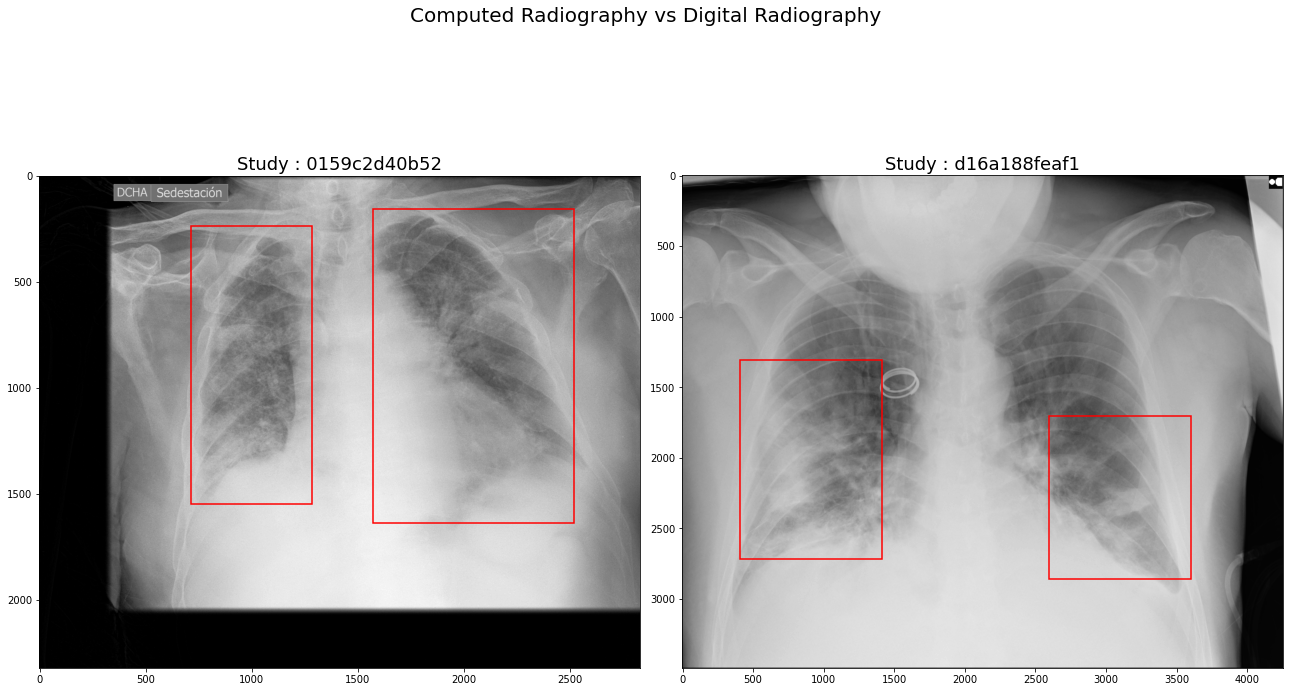

In [43]:
def get_modality_sample(df, modality):
    studyinstance = df.loc[(df['Modality'] == modality) & (df['PatientSex'] == 'M')].sample(n=1)['StudyInstanceUID'].values[0]
    return studyinstance
    #files = [file for file in all_files if studyinstance in file]
    #return files[0]

def get_modality_samples():
    modality_samples = []
    modality_samples.append(get_modality_sample(train_df,'CR'))
    modality_samples.append(get_modality_sample(train_df,'DX'))
    study_samples = []
    for study_instance_id in modality_samples:
        samples = []
        image = {}
        image_id = image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['id'].values[0].split('_')[0] #Get the image matching study id
        file_name = [string for string in all_files if image_id in string]
        image['study_id'] = study_instance_id
        image['dicom_file'] = file_name[0]
        #Get the bounding boxes
        box = None
        try:
            box = literal_eval(image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['boxes'].values[0])
        except ValueError:
            pass
        image['boxes'] = box
        study_samples.append(image)
        #study_samples[study_instance_id] = samples
    return study_samples

def display_modality_samples(samples, title, draw_boxes=False):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(1,2, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if draw_boxes == True and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=1.0)
#    plt.subplots_adjust(top=0.99)
    plt.suptitle(title,fontsize = 20)
    plt.show()

display_modality_samples(get_modality_samples(), 'Computed Radiography vs Digital Radiography', True)

### Photometric Interpretation

In DICOM, monochrome images are given a photometric interpretation of 'MONOCHROME1' (low values=bright, high values=dim) or 'MONOCHROME2' (low values=dark, high values=bright).

In [44]:
pi_train = train_df['PhotometricInterpretation'].value_counts().reset_index().rename(columns={'index':'PhotometricInterpretation','PhotometricInterpretation':'Count'})
pi_train['Type'] = 'Train'
pi_test = test_df['PhotometricInterpretation'].value_counts().reset_index().rename(columns={'index':'PhotometricInterpretation','PhotometricInterpretation':'Count'})
pi_test['Type'] = 'Test'
pi_df = pd.concat([pi_train, pi_test]).reset_index(drop=True)
bar_colors = ['#FFA48E', '#4ACFAC']
pi_values = list(pi_df.PhotometricInterpretation.unique())
fig = go.Figure()
for pi, color in zip(pi_values, bar_colors):
    df = pi_df.loc[pi_df['PhotometricInterpretation'] == pi]
    fig.add_trace(go.Bar(
        x=df['Type'],
        y=df['Count'],
        name=pi,
        marker_color = color,
        #text = df['passenger_count_new'],
        #texttemplate='%{text:.2s}', 
        textposition='auto',
        marker_line_width=2.5, opacity=0.8,
        marker_line_color = color        
    ))
fig.update_layout(barmode='stack',
                  xaxis=dict(
                                tickmode = 'array',
                                 title=None,
                                 showgrid=False,
                                 zeroline=False,
                            ),
                      yaxis=dict(title='Count',
                                 showgrid=False,
                                 zeroline=False,
                                ), 
                      title = dict(text = 'Photometric Interpretation of images',
                                   xref = 'paper',
                                  ),
                      bargap=0.15, 
                    bargroupgap=0.1,
                     )     
fig.show()

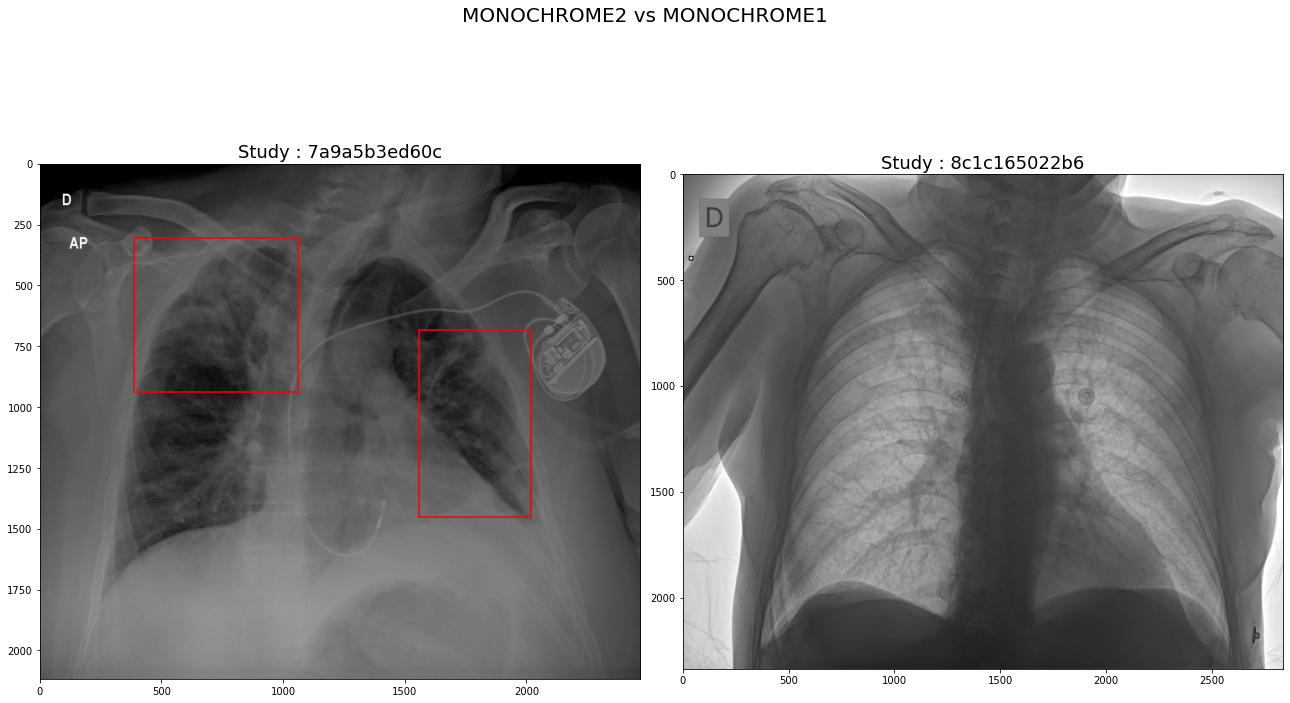

In [45]:
def get_photometricInterpretation_sample(df, modality):
    studyinstance = df.loc[(df['PhotometricInterpretation'] == modality) & (df['PatientSex'] == 'M')].sample(n=1)['StudyInstanceUID'].values[0]
    return studyinstance
    #files = [file for file in all_files if studyinstance in file]
    #return files[0]

def get_PhotometricInterpretation_samples():
    modality_samples = []
    modality_samples.append(get_photometricInterpretation_sample(train_df,'MONOCHROME2'))
    modality_samples.append(get_photometricInterpretation_sample(train_df,'MONOCHROME1'))
    study_samples = []
    for study_instance_id in modality_samples:
        samples = []
        image = {}
        image_id = image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['id'].values[0].split('_')[0] #Get the image matching study id
        file_name = [string for string in all_files if image_id in string]
        image['study_id'] = study_instance_id
        image['dicom_file'] = file_name[0]
        #Get the bounding boxes
        box = None
        try:
            box = literal_eval(image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['boxes'].values[0])
        except ValueError:
            pass
        image['boxes'] = box
        study_samples.append(image)
        #study_samples[study_instance_id] = samples
    return study_samples

def display_photometricInterpretation_samples(samples, title, draw_boxes=False):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(1,2, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if draw_boxes == True and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=1.0)
#    plt.subplots_adjust(top=0.99)
    plt.suptitle(title,fontsize = 20)
    plt.show()

display_photometricInterpretation_samples(get_PhotometricInterpretation_samples(), 'MONOCHROME2 vs MONOCHROME1', True)

#### Work in progress